# Demo of the robustness score
Sources:
1. [Summary on the robustness of interpretability methods [Medium]](https://medium.com/@mohamadt/summary-on-the-robustness-of-interpretability-methods-ffb26ba22776)
2. [On the Robustness of Interpretability Methods [Arxiv]](https://arxiv.org/pdf/1806.08049.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from lipschitz_metric import (lipschitz_metric,
                              get_perturbations,
                              explainer_func_wrapper)

## Combining LIME and Lipschitz robustness metric for classification
Let's import a dataset, train a simple classifier and use LIME to explain the model. Then, let's use the Lipschitz robustness score to check the stability of the explanations. To better illustrate the use case of the Lipschitz metric, notis that we set `tol=0.1`. This is a much higher tolerance than the default, and will stop the training earlier which in term leads to a less reliable model.

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from lime import lime_tabular

iris = load_iris(as_frame=True)
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = SVC(probability=True, tol=0.1)  # <-- NB! tol=0.1
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       1.00      0.94      0.97        16
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



Input: [5.  3.5 1.6 0.6]
Explanations: [('petal length (cm)', 0.2716185667036398), ('petal width (cm)', 0.05022375737166579), ('sepal width (cm)', -0.034601330278104886), ('sepal length (cm)', 0.022470773247744498)]


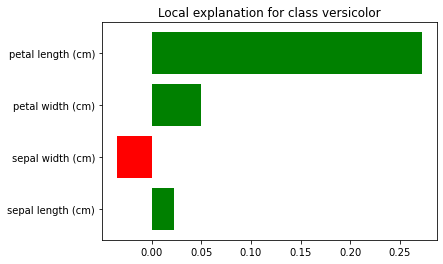

In [4]:
lime_explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=iris.feature_names, class_names=list(iris.target_names), discretize_continuous=False, sample_around_instance=True)

x0 = X_test.iloc[0].values

exp = lime_explainer.explain_instance(x0, model.predict_proba)

print(f"Input: {x0}")
print(f"Explanations: {exp.as_list()}")
exp.as_pyplot_figure();


### Calculating the Lipschitz robustness metric for one instance

We can use the Lipschitz metric as a measure of the stability of the explanations given by LIME. To do this, we create a functions that does three steps:

1. Wrap the explainer method of LIME so that it input the input to the ML-model and outputs the feature contributions
2. Calculate some small, random perturbations away from the input and the corresponding LIME explanations
3. Use the perturbations to calculate the L-metric

In [5]:
def get_L_metric(x0, input_space, x_range=None, num_perturbations=100):
    # Create a function that accepts the ML-model input and outputs the explainers feature contributions
    explainer_func = explainer_func_wrapper(
        predict_fn=model.predict_proba,
        explainer_handle=lime_explainer,
        explainer='lime'
    )

    # Calculate perturbations and the corresponding explanations
    x0, exp0, x_perturbations, exp_perturbations = get_perturbations(
        func=explainer_func,
        x0=x0,
        input_space=input_space,
        num_perturbations=num_perturbations
    )

    # Calculate the L-metric (and return the input that caused this L-metric)
    L, x_worst_case = lipschitz_metric(x0, exp0, x_perturbations, exp_perturbations, x_range=x_range)
    exp_worst_case = explainer_func(x_worst_case)

    return L, x0, exp0, x_worst_case, exp_worst_case

input_space = [(x_min, x_max) for x_min, x_max in zip(X_train.min(), X_train.max())]
x0 = X_test.iloc[0].values

L, x0, exp0, x_worst_case, exp_worst_case = get_L_metric(x0=x0, input_space=input_space, x_range=input_space)

print(f"Robustness score: {L:.2f}\n")
print("                                                                   Input     Output")
print(f"Original:   {str(x0):>60} --> {exp0}")
print(f"Worst-case: {str(x_worst_case):>60} --> {exp_worst_case}\n")
print(f"Diff:       {str(x_worst_case-x0):>60} --> {exp_worst_case-exp0}")

Robustness score: 2.60

                                                                   Input     Output
Original:                                            [[5.  3.5 1.6 0.6]] --> [[ 0.26810924  0.05089558 -0.03730178  0.0275072 ]]
Worst-case:                [5.00486897 3.5020929  1.59410925 0.59723099] --> [[ 0.26304697  0.0500425  -0.04089797  0.02508648]]

Diff:                [[ 0.00486897  0.0020929  -0.00589075 -0.00276901]] --> [[-0.00506226 -0.00085308 -0.00359619 -0.00242072]]


### Calculating the Lipschitz robustness metric for one instance
The example above calculated the Lipschitz metric for *one* instance. Let us now do the same thing for the whole test set. This will reveal where LIME has unstable explanations. 

(One could also sample the input space and calculate the Lipschitz metric for a larger area.)

In [6]:
input_space = [(x_min, x_max) for x_min, x_max in zip(X_train.min(), X_train.max())]
L_metric = []
x_worst_cases = {col: [] for col in X_test.columns}

for col, row in tqdm(X_test.iterrows(), total=X_test.shape[0]):
    x0 = row.values

    L, x0, exp0, x_worst_case, exp_worst_case = get_L_metric(x0=x0, input_space=input_space, x_range=input_space, num_perturbations=500)
    
    L_metric.append(L)
    for i, col in enumerate(x_worst_cases):
        x_worst_cases[col].append(x_worst_case[i])

X_test_analysis = X_test.copy()
X_test_analysis['L-metric'] = L_metric
for col, values in x_worst_cases.items():
    X_test_analysis[f'worst_case_{col}'] = values

100%|██████████| 38/38 [01:59<00:00,  3.15s/it]


In [7]:
X_test_analysis.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),L-metric,worst_case_sepal length (cm),worst_case_sepal width (cm),worst_case_petal length (cm),worst_case_petal width (cm)
43,5.0,3.5,1.6,0.6,3.027154,4.996420,3.515566,1.581031,0.595286
143,6.8,3.2,5.9,2.3,2.722648,6.809366,3.196857,5.941210,2.318859
91,6.1,3.0,4.6,1.4,6.092705,6.090476,2.989066,4.588494,1.388221
69,5.6,2.5,3.9,1.1,11.875580,5.613946,2.481918,3.883116,1.082612
37,4.9,3.6,1.4,0.1,2.940021,4.886240,3.589459,1.401797,0.104301


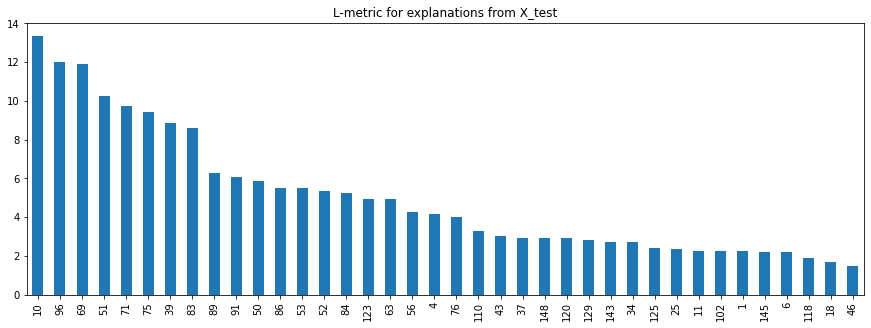

In [8]:
X_test_analysis['L-metric'].sort_values(ascending=False).plot.bar(figsize=(15,5), title='L-metric for explanations from X_test');

Input:        [5.4 3.7 1.5 0.2]
Perturbation: [5.40142402 3.71076432 1.48520101 0.20559425]


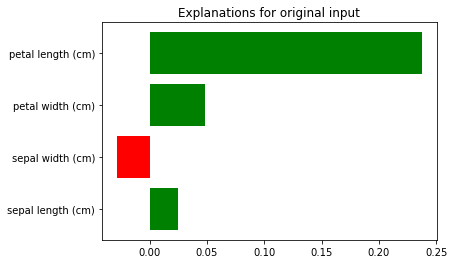

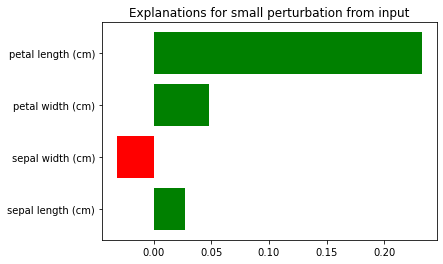

In [9]:
# Look closer at the point with the highest L-metric
worst_idx = X_test_analysis['L-metric'].argmax()
x0 = X_test_analysis.iloc[worst_idx, :4].values
x_perturbed = X_test_analysis.iloc[worst_idx, -4:].values

# Plot feature contribution for x0
lime_explainer.explain_instance(x0, model.predict_proba).as_pyplot_figure();
plt.title('Explanations for original input')
print(f"Input:        {x0}")

# Plot feature contribution for perturbation
lime_explainer.explain_instance(x0, model.predict_proba).as_pyplot_figure();
plt.title('Explanations for small perturbation from input')
print(f"Perturbation: {x_perturbed}")

As seen above, the test set containts multiple points where the LIME explanations are unstable. When looking closer at the most unstable point, we see that the feature contributions change dramatically, even though the input has barely changed.

## Educational example
Implement the metric describing the robustness of an explanation model in terms of its constant L in the definition of “local Lipschitz continuity”. For the example, implement using a simple predict method.

**Definition 2.1 (from [2]):**

$$
f \subseteq \mathbb{R}^n \rightarrow \mathbb{R}^m \textrm{is \textbf{Locally Lipschitz} if for every } x_0 \textrm{ there exists } \delta > 0 \textrm{ and } L \in \mathbb{R} \textrm{ such that } \|x - x_0\| < \delta \textrm{ implies } \|f(x) - f(x_0)\| < L\|x - x_0\|
$$

In essence, this formula says that for all perturbations $x$ around a given point $x_0$, a function is Locally Lipschitz if there exists some number $L$ that ensures that the difference in output $\|f(x) - f(x_0)\|$ is less than $L$ multiplied by the difference in input $\|x - x_0\|$. 

The paper argues that if we find the minimum value for $L$ that satisfies this condition, we can use that as a measure for stability.

Originally, the $L$ was meant to be calculated analytically. But since our ML-model cannot be expressed as an end-to-end differentiable function, the authors of [2] suggests using the following formula for approximating $L$:

$$
\tilde{L}_X(x_i) = \underset{x_j \in \mathcal{N}_\epsilon(x_i) \le \epsilon}{\mathrm{argmax}} \frac{\|f(x_i)-f(x_j)\|_2}{\|x_i-x_j\|_2}
$$
Where:
$$
\mathcal{N}_\epsilon(x_i) = \{ x_j \in X | \|x_i-x_j\| \le \epsilon \}
$$

The two formulas above basically mean that the stability metric $\tilde{L}_X(x_i)$ can be found by finding the largest deviation between the difference in both input and output, where the input should be based on a perturbations $x_j$ from a finite-sampled neighbourhood around $x_0$, such that the size of the perturbations are less than some small, "human-decided" number $\epsilon$

### An example

Testing the robustness score
Out function consists of two mathematical functions:

$$
\begin{align}
f_1(x) &= 3x_1 \\
f_2(x) &= 5x_2^2 + x_3
\end{align}
$$

The derivatives of these functions give us
$$
\begin{align}
\nabla f_1(x) &= \begin{bmatrix}
           3 \\
           0 \\
           0
         \end{bmatrix} \\

\nabla f_2(x) &= \begin{bmatrix}
           0 \\
           10x_2 \\
           1
         \end{bmatrix} \\
\end{align}
$$

Let's test two points, $(0,0,0)$ and $(0,1,0)$.
The point $(0,0,0)$ gives us the following derivatives:
$$
\begin{align}
\nabla f_1(0,0,0) &= \begin{bmatrix}
           3 \\
           0 \\
           0
         \end{bmatrix} \\

\nabla f_2(0,0,0) &= \begin{bmatrix}
           0 \\
           0 \\
           1
         \end{bmatrix} \\
\end{align}
$$

While the point $(0,1,0)$ gives us the following derivatives:
$$
\begin{align}
\nabla f_1(0,1,0) &= \begin{bmatrix}
           3 \\
           0 \\
           0
         \end{bmatrix} \\

\nabla f_2(0,1,0) &= \begin{bmatrix}
           0 \\
           10 \\
           1
         \end{bmatrix} \\
\end{align}
$$

The Lipschitz robustness score tries to find the largest derivative in any dimention for a given point.
From an analytical sense, this corresponds to `max(max(f1'(x*)), max(f2'(x*)))` for a given point $x^*$.
We should therefor expect the following results, when testing on our function, as $N \rightarrow \infty$:
```
lipschitz_robustness_score([0,0,0]) = 3
lipschitz_robustness_score([0,1,0]) = 10
```

In [10]:
predict = lambda x: np.array([3*x[:,0],
                              5*x[:,1]**2 + x[:,2]]).T

## Implementations

### Test using random samples

In [11]:
input_space = input_space = [(0, 100), (0, 3.14), (-5, 5)]
num_perturbations=100_000

x0s = np.array([[0,0,0], [0,1,0]])

for x0 in x0s:
    x0 = x0.reshape(1,-1)
    
    x0, y0, x_perturbations, y_perturbations = get_perturbations(predict, x0, input_space, num_perturbations=num_perturbations)
    L, L_input = lipschitz_metric(x0, y0, x_perturbations, y_perturbations)

    print(f"For x0={x0}, the robustness metric is {L:.2f} after {num_perturbations} perturbations, where the biggest gradient was found going from x0 to {L_input}")

For x0=[[0 0 0]], the robustness metric is 3.00 after 100000 perturbations, where the biggest gradient was found going from x0 to [7.83420167e-01 2.40477692e-05 4.18032194e-05]
For x0=[[0 1 0]], the robustness metric is 10.15 after 100000 perturbations, where the biggest gradient was found going from x0 to [8.50700073e-05 1.02429691e+00 3.78362505e-03]


### Test using pre-sampled perturbations
If the `predict()`-method is expensive to run, narrowing down the sample-space in a smart way could significantly reduce the execution time. Rather than sampling the input_space randomly, One could either create a grid-search or design a more deterministic approach based on knowledge about the data that only applied perturbations with meaningfull and desirable directions and magnitudes.

In [12]:
input_perturbations = np.array([
    [  0.1,     0,     0],
    [ -0.1,     0,     0],
    [    0,   0.1,     0],
    [    0,  -0.1,     0],
    [    0,     0,   0.1],
    [    0,     0,  -0.1],
    [ 0.01,  0.01,  0.01],
    [-0.01, -0.01, -0.01],
])

x0 = np.array([[0,0,0]])

x0, y0, x_perturbations, y_perturbations = get_perturbations(predict, x0, input_perturbations=input_perturbations)
L, L_input = lipschitz_metric(x0, y0, x_perturbations, y_perturbations)

print(f"For x0={x0}, the robustness metric is {L:.2f}, where the biggest gradient was found going from x0 to {L_input}")

For x0=[[0 0 0]], the robustness metric is 3.00, where the biggest gradient was found going from x0 to [0.1 0.  0. ]
